In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import spacy
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel

In [2]:
df = pd.read_csv("../data/clean_processed_tweet_data.csv")

In [3]:
Clean_Tweet = df[['original_text','polarity']]

In [4]:
def text_category (p):
  if p > 0:
    return 'positive'
  elif p < 0:
    return 'negative'
  else:
    return 'neutral'

/tmp/ipykernel_24506/1328451164.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels,fontsize=20)
/tmp/ipykernel_24506/1328451164.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


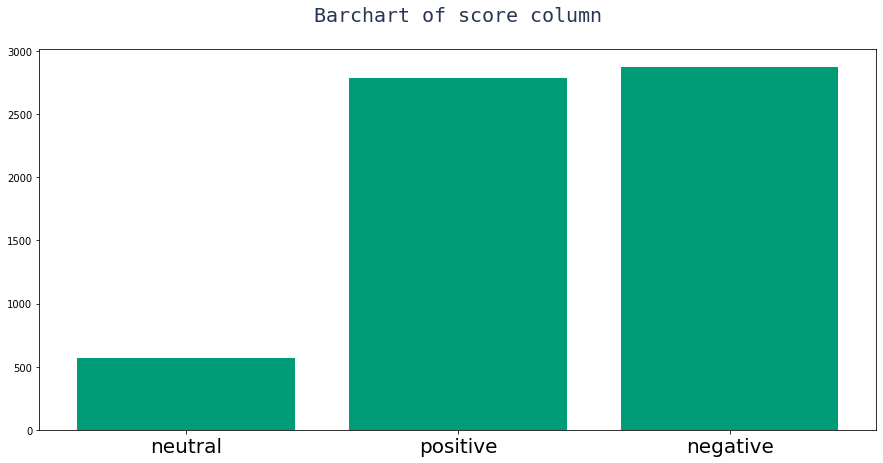

In [5]:
score = pd.Series([text_category(val) for val in Clean_Tweet['polarity']])
Clean_Tweet = pd.concat([Clean_Tweet, score.rename("score")], axis=1)

labels = ['neutral', 'positive', 'negative']
positive = len(Clean_Tweet[Clean_Tweet['score'] == "positive"])
negative = len(Clean_Tweet[Clean_Tweet['score'] == "negative"])
neutral = len(Clean_Tweet[Clean_Tweet['score'] == "neutral"])
fig, ax = plt.subplots(1, 1, figsize = (15,7))
ax.bar(x=labels, height=[negative, positive, neutral], color='#009B77')
ax.set_title('Barchart of score column\n',fontsize = 20,fontname = 'monospace', color = '#283655')
ax.set_xticklabels(labels,fontsize=20)

fig.show()

In [6]:
Clean_Tweet = Clean_Tweet.drop(Clean_Tweet[Clean_Tweet.score == 'neutral'].index)
scoremap = pd.Series([1 if val == 'positive' else 0 for val in Clean_Tweet['score']])
Clean_Tweet['scoremap'] = scoremap

<Figure size 432x288 with 0 Axes>

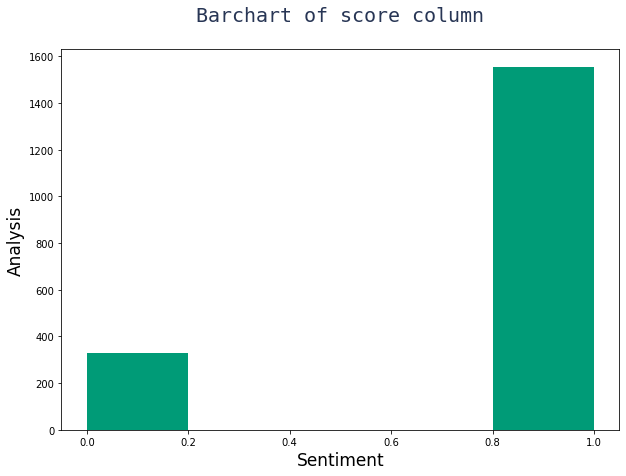

In [7]:
fig=plt.figure()
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.hist(Clean_Tweet['scoremap'],bins = 5,color='#009B77')
plt.title('Barchart of score column\n',fontsize = 20,fontname = 'monospace', color = '#283655')
plt.xlabel('Sentiment', fontsize=17)
plt.ylabel('Analysis', fontsize=17)
plt.show()

In [8]:
Clean_Tweet['original_text']=Clean_Tweet['original_text'].astype(str)
Clean_Tweet['original_text'] = Clean_Tweet['original_text'].apply(lambda x: x.lower())
Clean_Tweet['original_text']= Clean_Tweet['original_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [9]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/beth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

In [11]:
Clean_Tweet['original_text']=Clean_Tweet['original_text'].apply(remove_stopwords)

In [17]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [18]:
text_list=Clean_Tweet['original_text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

dr moeti head africa one best public health experts leaders know desperate request vaccines africa plead germany uk lift patent restrictions urgently transfer technology enable production africa httpstcosogiroihoc
['good', 'public', 'health', 'expert', 'leader', 'desperate', 'request', 'vaccine', 'lift', 'patent', 'restriction', 'technology']


In [19]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [20]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=500, passes=50,iterations=100)

In [21]:
lda_model.print_topics()

[(0,
  '0.041*"case" + 0.034*"death" + 0.033*"covid19" + 0.032*"coronavirus" + 0.026*"vaccine" + 0.025*"country" + 0.025*"amp" + 0.023*"week" + 0.021*"wave" + 0.021*"third"'),
 (1,
  '0.082*"vaccine" + 0.054*"covid19" + 0.026*"safe" + 0.019*"system" + 0.018*"safety" + 0.017*"doctor" + 0.014*"covidvaccination" + 0.013*"medical" + 0.012*"adverse" + 0.011*"possible"'),
 (2,
  '0.063*"vaccine" + 0.040*"risk" + 0.035*"good" + 0.034*"public" + 0.030*"health" + 0.030*"people" + 0.029*"covid19" + 0.026*"expert" + 0.025*"technology" + 0.024*"leader"'),
 (3,
  '0.057*"vaccine" + 0.055*"covid19" + 0.030*"third" + 0.029*"wave" + 0.029*"health" + 0.027*"oxygen" + 0.025*"case" + 0.024*"dose" + 0.023*"midst" + 0.022*"covid"'),
 (4,
  '0.147*"vaccine" + 0.057*"covid19" + 0.035*"dose" + 0.035*"vaccination" + 0.030*"world" + 0.026*"day" + 0.019*"today" + 0.017*"huge" + 0.016*"way" + 0.016*"2nd"')]

In [22]:
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
LDAvis_prepared

/home/beth/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.014412 -0.169212       1        1  28.576581
3      0.156412 -0.047670       2        1  22.613827
0      0.204837  0.220581       3        1  18.191637
2     -0.293406  0.168198       4        1  16.542594
1     -0.053431 -0.171898       5        1  14.075362, topic_info=            Term        Freq       Total Category  logprob  loglift
0           case  557.000000  557.000000  Default  30.0000  30.0000
266  vaccination  429.000000  429.000000  Default  29.0000  29.0000
112         risk  282.000000  282.000000  Default  28.0000  28.0000
3          death  264.000000  264.000000  Default  27.0000  27.0000
163         dose  660.000000  660.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
152       worker   59.055873  187.173675   Topic5  -4.6265   0.8072
289      variant   66.318648  276.959030   Topic5  -4.5105   0.5313
149      patient   58.982141  240.411280   Topic5  -4.6277   0.5556
140         time   49.560190  140.603452   Topic5  -4.8018   0.9180
97           day   44.037502  365.709424   Topic5  -4.9199  -0.1561

[254 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2138      1  0.991352       21st
1025      1  0.997357        2nd
103       2  0.993648     action
334       5  0.994437    adverse
216       1  0.987007  afternoon
...     ...       ...        ...
153       3  0.055687      world
153       5  0.071854      world
115       1  0.238804       year
115       3  0.756212       year
357       4  0.982628      young

[260 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

In [23]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.301467557808713

Coherence Score:  0.33946659622307157
